# Notebook 03 — Insights, Conclusions, and Recommendations

## Surgical Trends and Case Mix Analysis with Anesthesia Utilization (2022–2025)

**Purpose:** Convert exploratory findings into **executive-ready** insights, conclusions, and practical recommendations for theatre operations and anaesthesia planning.

**Dataset columns (raw):** `MONTH, AGE, SEX, TYPE_OF_SURGERY, SPECIALTY, DIAGNOSIS, OPERATIONS, ANESTHESIA, YEAR, MONTH_NAME, YEAR_MONTH, AGE_NUM, AGE_YEARS, AGE_GROUP, ANESTHESIA_IMPUTED`


## Executive Summary

Across 2022–2025, theatre activity shows meaningful variation in volume and case-mix, with periods of elevated emergency burden that can disrupt elective throughput. The workload is concentrated in a small number of high-volume specialties, and anaesthesia utilization is dominated by General Anaesthesia with a substantial Regional component.

This notebook summarizes the **headline metrics**, presents the **most operationally relevant findings** (with compact supporting visuals), and provides **prioritized recommendations** plus a **monitoring KPI set**.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load cleaned master dataset
df = pd.read_excel(r"SURGICAL_MASTER_2022_2025.xlsx")

# --- Standardize core fields for this notebook (portfolio-safe) ---
df["YEAR_MONTH_DT"] = pd.to_datetime(df["YEAR_MONTH"], errors="coerce").dt.to_period("M").dt.to_timestamp()

# Surgery type (EM/EL)
df["TYPE_OF_SURGERY_STD"] = df["TYPE_OF_SURGERY"].astype(str).str.strip().str.upper()
df["SURGERY_TYPE_CLEAN"] = df["TYPE_OF_SURGERY_STD"].replace({"EM":"Emergency","EL":"Elective"})

# Specialty clean
df["SPECIALTY_CLEAN"] = df["SPECIALTY"].astype(str).str.strip()

# Anaesthesia group from ANESTHESIA
def group_anaesthesia(x):
    s = str(x).strip().upper()

    if s in ["GA", "G/A", "G.A", "GENERAL", "GENERAL ANAESTHESIA", "GENERAL ANESTHESIA"]:
        return "General"
    elif s in ["SA", "S.A", "S. A", "S/A", "SAB",
               "SPINAL", "SPINAL ANAESTHESIA", "SPINAL ANESTHESIA",
               "SADDLE BLOCK", "SPINAL BLOCK",
               "BLOCK", "WRIST BLOCK", "REGIONAL BLOCK"]:
        return "Regional"
    elif s in ["LA", "L/A", "LOCAL", "TOPICAL", "WALANT"]:
        return "Local"
    elif "SEDATION" in s or "MAC" in s:
        return "Sedation/MAC"
    elif "SA/GA" in s or "GA/SA" in s:
        return "Combined"
    else:
        return "Other"

df["ANESTHESIA_GROUP"] = df["ANESTHESIA"].apply(group_anaesthesia)

print("Rows:", len(df))
print("Date range:", df["YEAR_MONTH_DT"].min(), "to", df["YEAR_MONTH_DT"].max())
df.head()


Rows: 62459
Date range: 2022-01-01 00:00:00 to 2025-12-01 00:00:00


,MONTH,AGE,SEX,TYPE_OF_SURGERY,SPECIALTY,DIAGNOSIS,OPERATIONS,ANESTHESIA,YEAR,MONTH_NAME,YEAR_MONTH,AGE_NUM,AGE_YEARS,AGE_GROUP,ANESTHESIA_IMPUTED,YEAR_MONTH_DT,TYPE_OF_SURGERY_STD,SURGERY_TYPE_CLEAN,SPECIALTY_CLEAN,ANESTHESIA_GROUP
0,2022-01-01,27,MALE,EL,OPHTHA,CORNEAL LACERATION,CORNEAL REPAIR,LA,2022,January,2022-01,27.0,27.0,19–35,False,2022-01-01,EL,Elective,OPHTHA,Local
1,2022-01-01,9,MALE,EL,OPHTHA,CORNEAL PERFORATION,CORNEAL REPAIR,GA,2022,January,2022-01,9.0,9.0,6–12,False,2022-01-01,EL,Elective,OPHTHA,General
2,2022-01-01,32,FEMALE,EM,GYNAE,RIGHT ECTOPIC PREGNANCY,EXPLORATORY LAPAROTOMY/SALPINGECTOMY,GA,2022,January,2022-01,32.0,32.0,19–35,False,2022-01-01,EM,Emergency,GYNAE,General
3,2022-01-01,43,MALE,EM,GEN. SURGERY,MULTIPLE FACIAL LACERATION,DEBRIDEMENT/STITCHING,GA,2022,January,2022-01,43.0,43.0,36–60,False,2022-01-01,EM,Emergency,GEN. SURGERY,General
4,2022-01-01,22,MALE,EM,GEN. SURGERY,COMPLICATED APPENDICITS,APPENDICITS,GA,2022,January,2022-01,22.0,22.0,19–35,False,2022-01-01,EM,Emergency,GEN. SURGERY,General


## Headline Metrics (2022–2025)

The table below summarizes the core operational metrics used in this report.

In [4]:
# Headline metrics (computed from data)
total_cases = len(df)

em_cases = int((df["SURGERY_TYPE_CLEAN"]=="Emergency").sum())
el_cases = int((df["SURGERY_TYPE_CLEAN"]=="Elective").sum())

em_pct = em_cases/total_cases if total_cases else 0
el_pct = el_cases/total_cases if total_cases else 0

# Anaesthesia mix
ana_counts = df["ANESTHESIA_GROUP"].value_counts()
ga_cases = int(ana_counts.get("General", 0))
ra_cases = int(ana_counts.get("Regional", 0))
la_cases = int(ana_counts.get("Local", 0))

ga_pct = ga_cases/total_cases if total_cases else 0
ra_pct = ra_cases/total_cases if total_cases else 0
la_pct = la_cases/total_cases if total_cases else 0

# Top specialties (top 3)
top_specs = df["SPECIALTY_CLEAN"].value_counts().head(3)
top_specs_str = ", ".join([f"{k} ({v:,})" for k,v in top_specs.items()])

headline_df = pd.DataFrame({
    "Metric": [
        "Total surgeries (2022–2025)",
        "Emergency cases",
        "Emergency share",
        "Elective cases",
        "Elective share",
        "General Anaesthesia cases",
        "GA share",
        "Regional Anaesthesia cases",
        "Regional share",
        "Local Anaesthesia cases",
        "Local share",
        "Top specialties (by volume)"
    ],
    "Value": [
        f"{total_cases:,}",
        f"{em_cases:,}",
        f"{em_pct:.1%}",
        f"{el_cases:,}",
        f"{el_pct:.1%}",
        f"{ga_cases:,}",
        f"{ga_pct:.1%}",
        f"{ra_cases:,}",
        f"{ra_pct:.1%}",
        f"{la_cases:,}",
        f"{la_pct:.1%}",
        top_specs_str
    ]
})
headline_df


,Metric,Value
0,Total surgeries (2022–2025),"62,459"
1,Emergency cases,"30,457"
2,Emergency share,48.8%
3,Elective cases,"32,002"
4,Elective share,51.2%
5,General Anaesthesia cases,"40,085"
6,GA share,64.2%
7,Regional Anaesthesia cases,"17,637"
8,Regional share,28.2%
9,Local Anaesthesia cases,"2,745"


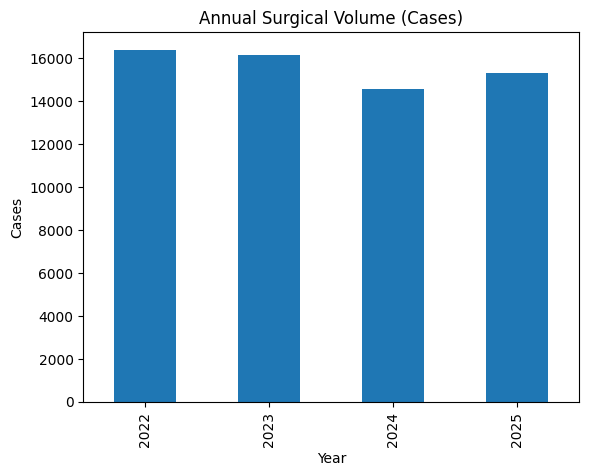

YEAR
2022    16408
2023    16155
2024    14564
2025    15332
dtype: int64

In [5]:
# Annual volume
df["YEAR"] = pd.to_datetime(df["YEAR_MONTH_DT"]).dt.year
annual = df.groupby("YEAR").size().sort_index()

plt.figure()
annual.plot(kind="bar")
plt.title("Annual Surgical Volume (Cases)")
plt.xlabel("Year")
plt.ylabel("Cases")
plt.show()

annual


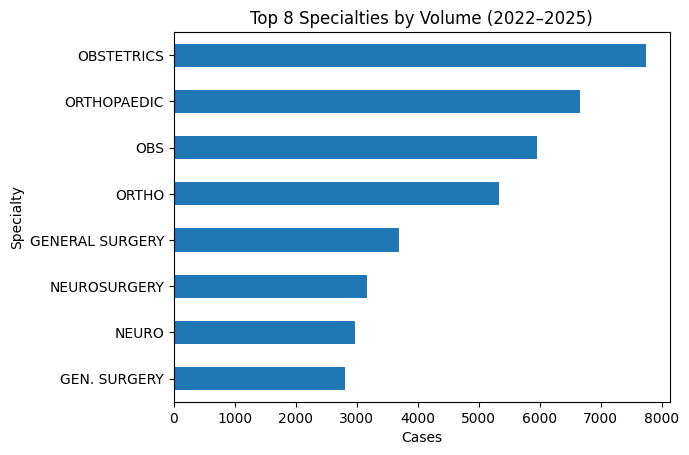

GEN. SURGERY       2801
NEURO              2968
NEUROSURGERY       3175
GENERAL SURGERY    3698
ORTHO              5340
OBS                5952
ORTHOPAEDIC        6668
OBSTETRICS         7747
Name: SPECIALTY_CLEAN, dtype: int64

In [6]:
# Top 8 specialties by volume
top_n = 8
spec = df["SPECIALTY_CLEAN"].value_counts().head(top_n).sort_values()

plt.figure()
spec.plot(kind="barh")
plt.title(f"Top {top_n} Specialties by Volume (2022–2025)")
plt.xlabel("Cases")
plt.ylabel("Specialty")
plt.show()

spec


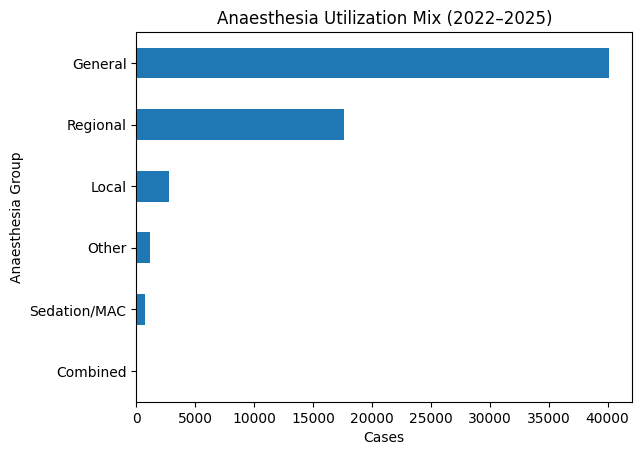

,share
Combined,0.000592
Sedation/MAC,0.012072
Other,0.019229
Local,0.043949
Regional,0.282377
General,0.641781


In [7]:
# Anaesthesia utilization mix
ana = df["ANESTHESIA_GROUP"].value_counts().sort_values()

plt.figure()
ana.plot(kind="barh")
plt.title("Anaesthesia Utilization Mix (2022–2025)")
plt.xlabel("Cases")
plt.ylabel("Anaesthesia Group")
plt.show()

(ana/ana.sum()).rename("share").to_frame()


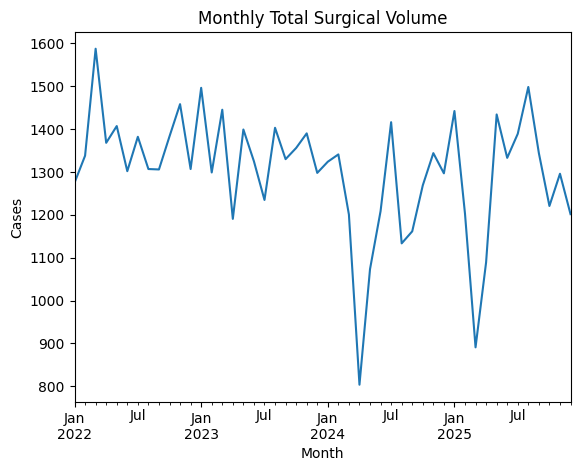

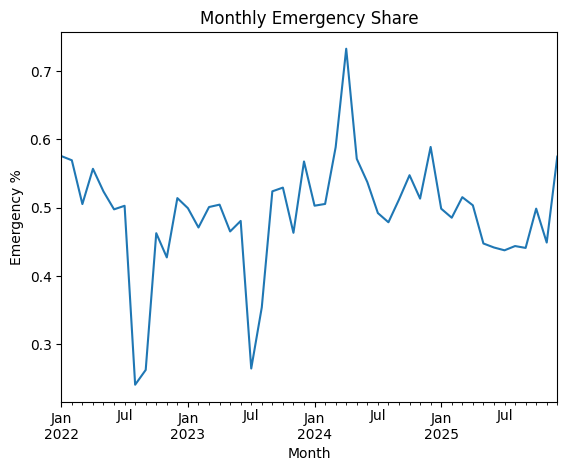

,total_cases,emergency_cases,emergency_pct
YEAR_MONTH_DT,,,
2025-08-01,1497,664,0.443554
2025-09-01,1343,592,0.440804
2025-10-01,1220,608,0.498361
2025-11-01,1295,581,0.448649
2025-12-01,1201,690,0.574521


In [8]:
# Monthly total volume and emergency share
monthly = df.dropna(subset=["YEAR_MONTH_DT"]).groupby("YEAR_MONTH_DT").agg(
    total_cases=("YEAR_MONTH_DT","size"),
    emergency_cases=("SURGERY_TYPE_CLEAN", lambda s: (s=="Emergency").sum())
).sort_index()
monthly["emergency_pct"] = monthly["emergency_cases"]/monthly["total_cases"]

plt.figure()
monthly["total_cases"].plot()
plt.title("Monthly Total Surgical Volume")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.show()

plt.figure()
monthly["emergency_pct"].plot()
plt.title("Monthly Emergency Share")
plt.xlabel("Month")
plt.ylabel("Emergency %")
plt.show()

monthly.tail()


## Key Findings (Most Operationally Relevant)

1) **Volume variability:** Annual and monthly volumes fluctuate, indicating periods of reduced throughput that should be reviewed alongside staffing, supply constraints, and operational disruptions.

2) **Emergency burden:** Emergency share remains consistently high with spikes in some periods. High emergency months are likely to disrupt elective schedules and increase overtime pressure.

3) **Workload concentration:** A small number of specialties account for a large share of theatre activity. This supports specialty-aligned scheduling templates and targeted supply planning.

4) **Anaesthesia utilization:** General Anaesthesia dominates overall demand, with a substantial Regional workload. This has direct implications for anaesthesia rosters, skill mix, and on-call coverage.


## Recommendations (Prioritized)

### Quick wins (0–3 months)
1. **Align anaesthesia staffing to specialty lists:** Match GA-heavy specialties with consistent GA capacity; maintain regional expertise for obstetric/orthopaedic sessions.
2. **Introduce a monthly theatre dashboard:** Track volume, emergency share, top specialties, and anaesthesia mix for rapid operational visibility.
3. **Protect elective throughput during emergency spikes:** Implement “protected elective lists” and escalation rules for emergency overflow.

### Mid-term (3–12 months)
4. **Specialty-based theatre block scheduling:** Allocate sessions proportional to observed specialty demand to reduce list overruns and cancellations.
5. **Supply planning by case-mix:** Prioritize procurement for the dominant specialties and sustain emergency readiness for high-burden services.
6. **Anaesthesia skills planning:** Maintain training and rota balance for GA and regional/spinal techniques; audit combined cases where applicable.

### Strategic (12+ months)
7. **Forecast-driven capacity planning:** Use forecasts (Notebook 04) to plan staffing and theatre allocation for peak months.
8. **Expand data capture for efficiency modelling:** Add case duration, turnover time, cancellations, and outcomes to enable theatre efficiency and optimization modelling.


## KPI Monitoring Set (Monthly)

- **Total surgical volume** (cases)
- **Emergency share** (%)
- **Elective share** (%)
- **Top 8 specialty distribution**
- **Anaesthesia utilization** (% GA / Regional / Local)
- **Data quality** (% missing/unknown in key fields)


## Limitations and Next Steps

**Limitations**
- No theatre time metrics (case duration, turnover, start delays), limiting efficiency analysis.
- No cancellations/reasons or outcomes, limiting productivity and quality-of-care analysis.

**Next steps**
- Integrate case duration and turnover fields to quantify theatre efficiency.
- Add cancellations and reasons to quantify elective disruption.
- Build an executive dashboard (Power BI/Tableau) for monthly monitoring.
